# Прогнозирование оттока банковских клиентов

### Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Необходимо:

1. Построить модель с предельно большим значением F1-меры. 
2. Довести метрику до 0.59. 
3. Проверить F1-меру на тестовой выборке.
4. Дополнительно измерить AUC-ROC, сравнить её значение с F1-мерой.

### Описание данных

**Признаки:**

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

**Целевой признак:**

- `Exited` — факт ухода клиента

### Импорт необходимых библиотек и модулей

In [1]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMClassifier

# импорты модулей текущего проекта
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    precision_recall_curve,
    recall_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.utils import shuffle

# настройки
warnings.filterwarnings("ignore")

# константы
RANDOM_STATE = 42

### Предобработка данных

In [2]:
data = pd.read_csv('C:/Users/Olga/datasets/Churn.csv')
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В столбце Tenure есть пропуски, заменим их на медианное значение. При этом, сравним характеристики распределения (mean, std, median) до и после заполнения. Если изменения будут некритичны, тогда заполнение пропусков медианой можно считать корректным. 

Также, изменим тип данных в Tenure на int. Названия столбцов приведем в нижнему регистру.

In [4]:
data.columns = data.columns.str.lower()

In [5]:
data['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

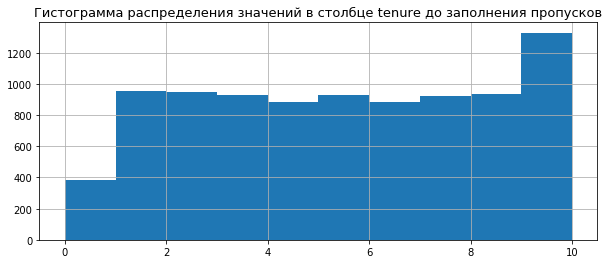

In [6]:
plt.figure(figsize=(10,4))
data['tenure'].hist(grid=True)
plt.title('Гистограмма распределения значений в столбце tenure до заполнения пропусков', size=13)
plt.show()

In [7]:
data['tenure'] = data['tenure'].fillna(data['tenure'].median())

In [8]:
data['tenure'].describe()

count    10000.00000
mean         4.99790
std          2.76001
min          0.00000
25%          3.00000
50%          5.00000
75%          7.00000
max         10.00000
Name: tenure, dtype: float64

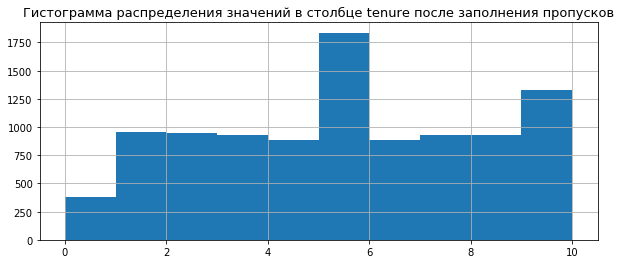

In [9]:
plt.figure(figsize=(10,4))
data['tenure'].hist(grid=True)
plt.title('Гистограмма распределения значений в столбце tenure после заполнения пропусков', size=13)
plt.show()

После заполнения пропусков медианным значением в распределени наблюдается всплеск в районе отметки 5. Однако, значения среднего (mean = 4.997) и медианы (50% = 5.0) не изменились, а стандартное отклонение std изменилось не значительно: уменьшилось с 2.894723 до 2.76001. Учитывая это, а также тот факт, что пропущенных значений было менее 10% (то есть после заполнения возможная доля искаженных данных составляет менее 0.1), будем считать, что заполнение пропусков проведено корректно.

In [10]:
# Приведем значения в столбце tenure к целочисленному типу

data['tenure'] = data['tenure'].astype('int')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
rownumber          10000 non-null int64
customerid         10000 non-null int64
surname            10000 non-null object
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null int32
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(2), int32(1), int64(8), object(3)
memory usage: 1.0+ MB


Проверим признаки на мультиколлинеарность:

In [12]:
data.corr().style.background_gradient(axis=None, cmap='YlOrRd')

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
rownumber,1,0.00420179,0.00584016,0.000782614,-0.00697898,-0.00906669,0.00724625,0.000598747,0.0120444,-0.00598846,-0.0165714
customerid,0.00420179,1,0.0053079,0.00949687,-0.0203306,-0.0124187,0.0169719,-0.0140251,0.00166496,0.0152707,-0.00624799
creditscore,0.00584016,0.0053079,1,-0.00396491,-6.03197e-05,0.00626838,0.0122379,-0.00545848,0.0256513,-0.00138429,-0.0270935
age,0.000782614,0.00949687,-0.00396491,1,-0.0126061,0.0283084,-0.0306801,-0.011721,0.0854721,-0.00720104,0.285323
tenure,-0.00697898,-0.0203306,-6.03197e-05,-0.0126061,1,-0.0075348,0.0114087,0.025979,-0.0306808,0.010049,-0.0159889
balance,-0.00906669,-0.0124187,0.00626838,0.0283084,-0.0075348,1,-0.30418,-0.0148583,-0.0100841,0.0127975,0.118533
numofproducts,0.00724625,0.0169719,0.0122379,-0.0306801,0.0114087,-0.30418,1,0.00318315,0.00961188,0.0142042,-0.0478199
hascrcard,0.000598747,-0.0140251,-0.00545848,-0.011721,0.025979,-0.0148583,0.00318315,1,-0.0118656,-0.00993341,-0.00713777
isactivemember,0.0120444,0.00166496,0.0256513,0.0854721,-0.0306808,-0.0100841,0.00961188,-0.0118656,1,-0.0114214,-0.156128
estimatedsalary,-0.00598846,0.0152707,-0.00138429,-0.00720104,0.010049,0.0127975,0.0142042,-0.00993341,-0.0114214,1,0.0120969


Мультиколлинеарность не обнаружена. 

### Подготовка данных. Разделение на выборки

Опишем типы признаков в отдельных списках, выделив неинформативные (чтобы в дальнейшем исключить их при обучении модели), а также категориальные и числовые.

In [13]:
categorical_features = ['geography', 'gender', ]  
numeric_features = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary', 'hascrcard', 'isactivemember']  
not_informative = ['rownumber', 'customerid', 'surname']  
target_name = 'exited'

Удалим неинформативные признаки  и разобьем датасет на выборки:

In [14]:
# Отбрасываем неинформативные признаки:
data = data.drop(columns=not_informative)

In [15]:
# Делим признаки на фичи и таргет:
X = data.drop(columns=target_name, axis=1)
y = data[target_name]

# Разбиваем на выборки - обучающую, валидационную и тестовую:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(6000, 10)
(2000, 10)
(2000, 10)


Подготавливаем признаки для передачи в Pipeline: кодируем категориальные, масштабируем числовые.

In [16]:
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first'),
        categorical_features
    ),
    (
        StandardScaler(), 
        numeric_features
    ),
    remainder='passthrough'
)

### Вспомогательные функции

Прежде чем переходить к работе с моделями, создаим несколько вспомогательных функций:

- функция для расчета основных метрик(метрики будем считать на валидационной выборке),
- функция для построения графиков: Кривая Precision-Recall и ROC-кривая,
- функция для создания результирующей таблицы метрик,
- вспомогательные функции, возвращающие значения метрик F1 и AUC-ROC - для создания результирующей таблицы.

In [17]:
# Функция расчета метрик

def metrics_calc(model, pipline): 
    # Посчитаем предсказание
    predicted_valid = model.predict(X_valid)
    
    # Посчитаем Accuracy
    accuracy_valid = accuracy_score(y_valid, predicted_valid)
    
    # Посчитаем f1-меру (нужна близко к единице, по заданию не менее 0.59)
    f1_valid = f1_score(y_valid, predicted_valid)
    
    # Посчитаем полноту (хорошо когда близко единице)
    recall_valid = recall_score(y_valid, predicted_valid)
    
    # Посчитаем точность (нужна точность близкая к единице)
    precision_valid = precision_score(y_valid, predicted_valid)
    
    # Посчитаем вероятности
    probabilities_valid = model.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    # Расчет AUC-ROC
    auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
    
    # Вывод результатов
    print('Метрики для модели:', pipline.steps[1][1]) #type(model).__name__) #, model.best_estimator_)
    print()
    print('Accuracy модели на валидационной выборке:', accuracy_valid.round(2))
    print('Полнота модели на валидационной выборке:', recall_valid.round(2))
    print('Точность модели на валидационной выборке:', precision_valid.round(2))
    print('Площадь под ROC-кривой - AUC-ROC:', auc_roc.round(2))
    print('Значение F1-меры модели на валидационной выборке:', f1_valid.round(3))
    print()
    print('###########################################################')
    print()
    return

In [18]:
# Функция постоения графиков

def showplot(model, title):
    probabilities_valid = model.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
    
    # График Precision-Recal
    precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_one_valid)
    
    # График ROC-кривой
    fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
    
    # Построение графиков
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall')
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % auc_roc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('ROC-кривая')
    
    plt.suptitle(title)
    plt.show()

    return

In [19]:
# Функция расчета метрики F1 для использования в результирующей таблице

def f1_calc(model):
    predicted_valid = model.predict(X_valid)
    f1_valid = f1_score(y_valid, predicted_valid)
    
    return f1_valid.round(3)

In [20]:
# Функция расчета метрики AUC-ROC для использования в результирующей таблице

def auc_calc(model): 
    probabilities_valid = model.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
    
    return auc_roc.round(2)

In [21]:
# Подготовим результирующую таблицу 

results = pd.DataFrame({'Метод борьбы с дисбалансом':[], 'Learning model':[], 'F1-score':[], 'AUC-ROC':[]})

# Функция для вывода результирующей таблицы

def results_table(model, pipline, contre_disbalance_way:str):
    globals()['results'] = globals()['results'].append(
      {'Метод борьбы с дисбалансом' : contre_disbalance_way, 
       'Learning model': pipline.steps[1][1], #model.best_estimator_, #type(model).__name__, 
       'F1-score': f1_calc(model),
       'AUC-ROC': auc_calc(model)
      }, 
          ignore_index=True)
    
    return

### Модели

Для сравнения обучим 4 модели: 
   - DecisionTreeClassifier, 
   - LogisticRegression, 
   - RandomForestClassifer,
   - LGBMClassifier.

Подбор гиперпараметров будем осуществлять с помощью GridSearchCV

In [22]:
# Создадим списки параметров для перебора в GridSearchCV
# Последовательнось предобработки признаков будет задаваться через Pipeline 

# DecisionTreeClassifier()
dtc_grid_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
                   'decisiontreeclassifier__max_depth': range(1, 5),
                   'decisiontreeclassifier__min_samples_split': [2, 3, 4]
                  }

# LogisticRegression
lr_grid_params = {'logisticregression__solver' : ['liblinear', 'saga'],
                  'logisticregression__C' : (5, 7, 9, 10),
                  'logisticregression__penalty' : ['l1', 'l2']
                 }

# RandomForestClassifier()
rfc_grid_params = {'randomforestclassifier__n_estimators': range(50, 251, 50),
                   'randomforestclassifier__max_depth': range(2, 15),
                   'randomforestclassifier__min_samples_split': (2, 3, 4)
                  }


# LGBMClassifier
lgbm_grid_params = {'lgbmclassifier__n_estimators': [100, 200, 300],
                    'lgbmclassifier__learning_rate': [0.1, 0.3]
                   }

#### 1. Обучение без учета дисбаланса классов

In [23]:
%%time

# GridSearch DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
pipline_dtc = make_pipeline(col_transformer, model)
dtc_gs = GridSearchCV(pipline_dtc, param_grid=dtc_grid_params, cv=3, n_jobs=-1, scoring='f1')
dtc_gs.fit(X_train, y_train) 

Wall time: 5.86 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categorical_features=None,
                                                                                       categories=None,
                                                                                       drop='first',
                                                                                       dtype=<class 'numpy.float64'

In [24]:
%%time

# GridSearch LogisticRegression
model = LogisticRegression(random_state=RANDOM_STATE)
pipline_lr = make_pipeline(col_transformer, model)
lr_gs = GridSearchCV(pipline_lr, param_grid=lr_grid_params, cv=3, n_jobs=-1, scoring='f1')
lr_gs.fit(X_train, y_train)

Wall time: 1.25 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categorical_features=None,
                                                                                       categories=None,
                                                                                       drop='first',
                                                                                       dtype=<class 'numpy.float64'

In [25]:
%%time

# GridSearch RandomForestClassifier
model = RandomForestClassifier(random_state=RANDOM_STATE)
pipline_rfc = make_pipeline(col_transformer, model)
rfc_gs = GridSearchCV(pipline_rfc, param_grid=rfc_grid_params, cv=3, n_jobs=-1, scoring='f1')
rfc_gs.fit(X_train, y_train)

Wall time: 3min 23s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categorical_features=None,
                                                                                       categories=None,
                                                                                       drop='first',
                                                                                       dtype=<class 'numpy.float64'

In [26]:
%%time

# GridSearch LGBMClassifier
model = LGBMClassifier(random_state=RANDOM_STATE)
pipline_lgbm = make_pipeline(col_transformer, model)
lgbm_gs = GridSearchCV(pipline_lgbm, param_grid=lgbm_grid_params, cv=3, n_jobs=-1, scoring='f1')
lgbm_gs.fit(X_train, y_train)

Wall time: 4.6 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categorical_features=None,
                                                                                       categories=None,
                                                                                       drop='first',
                                                                                       dtype=<class 'numpy.float64'

In [27]:
# Списки моделей без учета дисбаланса классов для расчета метрик и результирующей таблицы:

models = [
    dtc_gs.best_estimator_,
    lr_gs.best_estimator_,
    rfc_gs.best_estimator_,
    lgbm_gs.best_estimator_
]
piplines = [
    pipline_dtc, 
    pipline_lr, 
    pipline_rfc, 
    pipline_lgbm
]

In [28]:
for i in range(len(models)):
    metrics_calc(models[i], piplines[i])

Метрики для модели: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

Accuracy модели на валидационной выборке: 0.83
Полнота модели на валидационной выборке: 0.42
Точность модели на валидационной выборке: 0.58
Площадь под ROC-кривой - AUC-ROC: 0.73
Значение F1-меры модели на валидационной выборке: 0.488

###########################################################

Метрики для модели: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='war

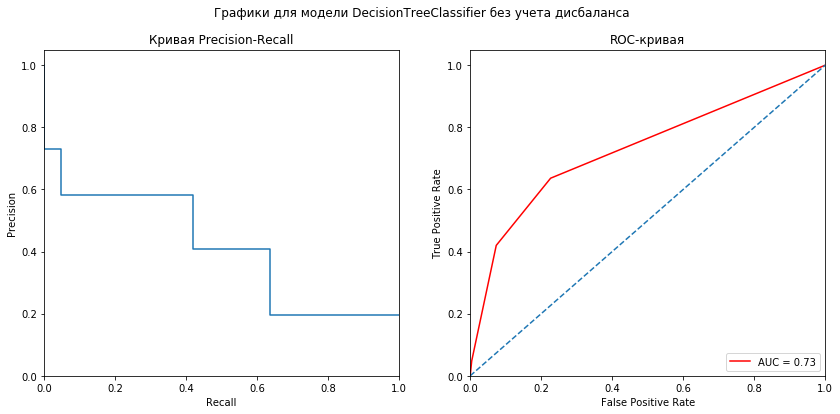

In [29]:
showplot(dtc_gs.best_estimator_, 'Графики для модели DecisionTreeClassifier без учета дисбаланса')

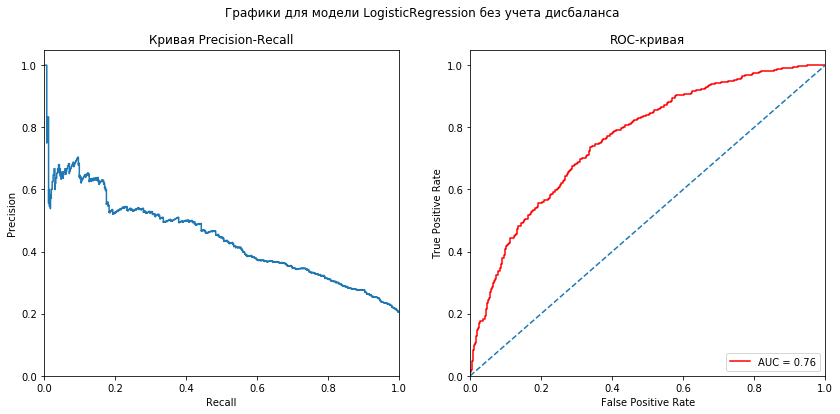

In [30]:
showplot(lr_gs.best_estimator_, 'Графики для модели LogisticRegression без учета дисбаланса')

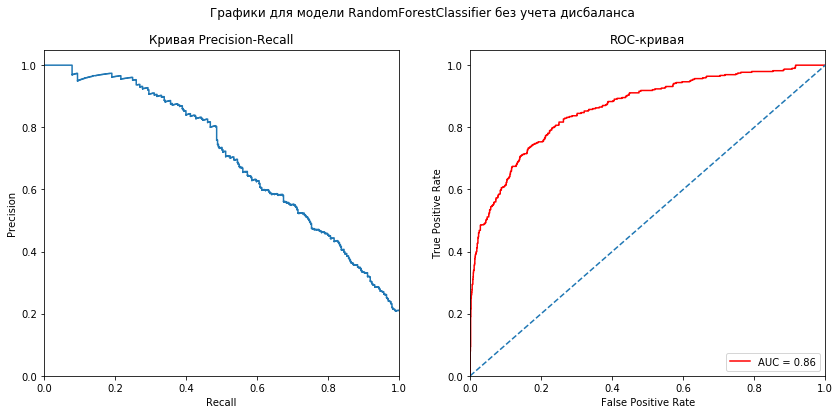

In [31]:
showplot(rfc_gs.best_estimator_, 'Графики для модели RandomForestClassifier без учета дисбаланса')

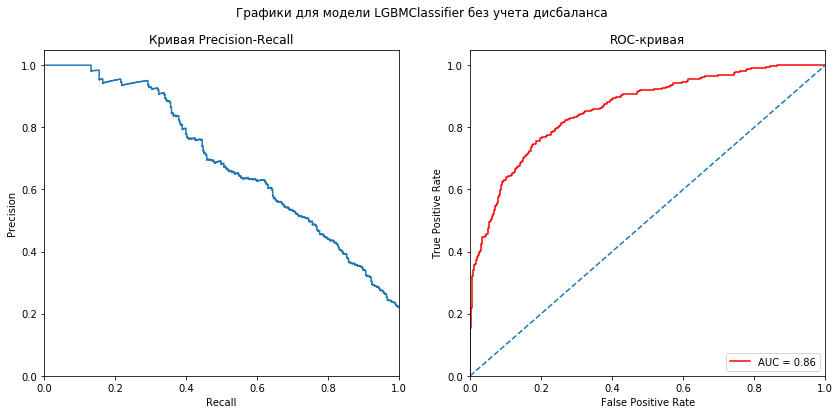

In [32]:
showplot(lgbm_gs.best_estimator_, 'Графики для модели LGBMClassifier без учета дисбаланса')

In [33]:
for i in range(len(models)):
    results_table(models[i], piplines[i], 'Без учета дисбаланса')

In [34]:
results.style.background_gradient(axis=0, cmap='YlOrRd')

,Метод борьбы с дисбалансом,Learning model,F1-score,AUC-ROC
0,Без учета дисбаланса,"DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best')",0.488,0.73
1,Без учета дисбаланса,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)",0.275,0.76
2,Без учета дисбаланса,"RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False)",0.604,0.86
3,Без учета дисбаланса,"LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, importance_type='split', learning_rate=0.1, max_depth=-1, min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31, objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0, subsample_for_bin=200000, subsample_freq=0)",0.58,0.86


Значение F1-меры без учета дисбаланса классов достгиет значения 0.6 только у модели `RandomForestClassifier`. 
Очевидно, что необходимо исследовать данные на дисбаланс и выровнять его, а потом заново обучить модель. 

#### Исследование данных на дисбаланс классов.

Проверим целевой признак

Распределения значений в столбце exited:
0    0.7963
1    0.2037
Name: exited, dtype: float64



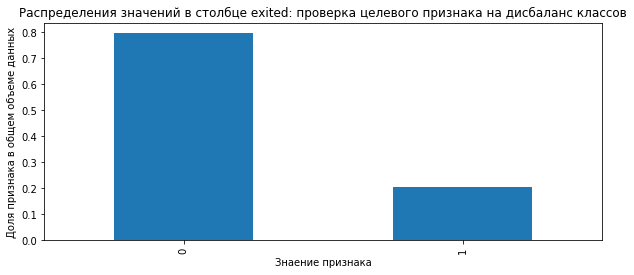

In [35]:
class_frequency = data['exited'].value_counts(normalize=True)
print('Распределения значений в столбце exited:')
print(class_frequency)
print()
plt.figure(figsize=(10,4))
class_frequency.plot(kind='bar')
plt.title('Распределения значений в столбце exited: проверка целевого признака на дисбаланс классов', size=12)
plt.xlabel('Знаение признака', size=10)
plt.ylabel('Доля признака в общем объеме данных', size=10)
plt.show()

В нашей задаче наблюдается сильный дисбаланс классов, что плохо сказывается на обучении модели.

#### 2. Устранение дисбаланса гиперпараметром class_weight = 'balanced'

Для балансировки весов применим при обучении гиперпараметр class_weight = 'balanced'. Как и в предыдущий раз, обучим четыре модели.

In [36]:
%%time

# GridSearch DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')
pipline_balanced_dtc = make_pipeline(col_transformer, model)
dtc_balanced_gs = GridSearchCV(pipline_balanced_dtc, param_grid=dtc_grid_params, cv=3, n_jobs=-1, scoring='f1')
dtc_balanced_gs.fit(X_train, y_train) 

Wall time: 1.62 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categorical_features=None,
                                                                                       categories=None,
                                                                                       drop='first',
                                                                                       dtype=<class 'numpy.float64'

In [37]:
%%time

# GridSearch LogisticRegression
model = LogisticRegression(random_state=RANDOM_STATE, class_weight = 'balanced')
pipline_balanced_lr = make_pipeline(col_transformer, model)
lr_balanced_gs = GridSearchCV(pipline_balanced_lr, param_grid=lr_grid_params, cv=3, n_jobs=-1, scoring='f1')
lr_balanced_gs.fit(X_train, y_train)

Wall time: 1.24 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categorical_features=None,
                                                                                       categories=None,
                                                                                       drop='first',
                                                                                       dtype=<class 'numpy.float64'

In [38]:
%%time

# GridSearch RandomForestClassifier
model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')
pipline_balanced_rfc = make_pipeline(col_transformer, model)
rfc_balanced_gs = GridSearchCV(pipline_balanced_rfc, param_grid=rfc_grid_params, cv=3, n_jobs=-1, scoring='f1')
rfc_balanced_gs.fit(X_train, y_train)

Wall time: 3min 8s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categorical_features=None,
                                                                                       categories=None,
                                                                                       drop='first',
                                                                                       dtype=<class 'numpy.float64'

In [39]:
%%time

# GridSearch LGBMClassifier
model = LGBMClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')
pipline_balanced_lgbm = make_pipeline(col_transformer, model)
lgbm_balanced_gs = GridSearchCV(pipline_balanced_lgbm, param_grid=lgbm_grid_params, cv=3, n_jobs=-1, scoring='f1')
lgbm_balanced_gs.fit(X_train, y_train)

Wall time: 3.27 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categorical_features=None,
                                                                                       categories=None,
                                                                                       drop='first',
                                                                                       dtype=<class 'numpy.float64'

In [40]:
# Список моделей с учетом балансировки классов для расчета метрик и результирующей таблицы:

models_balanced = [
    dtc_balanced_gs.best_estimator_,
    lr_balanced_gs.best_estimator_,
    rfc_balanced_gs.best_estimator_,
    lgbm_balanced_gs.best_estimator_
]
piplines_balanced = [
    pipline_balanced_dtc, 
    pipline_balanced_lr, 
    pipline_balanced_rfc, 
    pipline_balanced_lgbm
]

In [41]:
for i in range(len(models_balanced)):
    metrics_calc(models_balanced[i], piplines_balanced[i])

Метрики для модели: DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

Accuracy модели на валидационной выборке: 0.78
Полнота модели на валидационной выборке: 0.66
Точность модели на валидационной выборке: 0.46
Площадь под ROC-кривой - AUC-ROC: 0.81
Значение F1-меры модели на валидационной выборке: 0.538

###########################################################

Метрики для модели: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42,

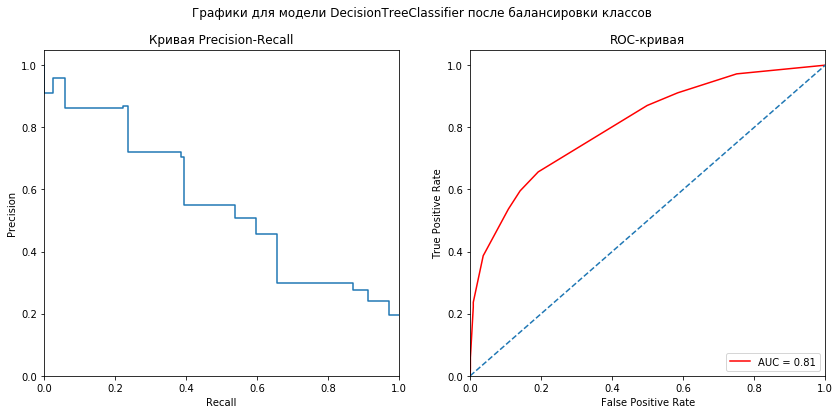

In [42]:
showplot(dtc_balanced_gs.best_estimator_, 'Графики для модели DecisionTreeClassifier после балансировки классов')

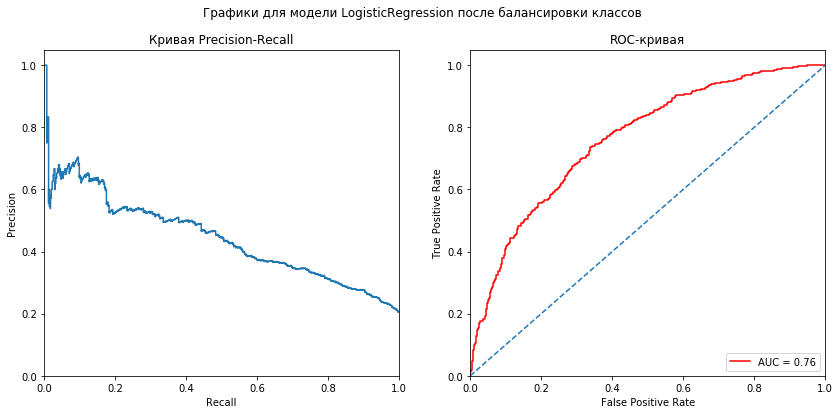

In [43]:
showplot(lr_gs.best_estimator_, 'Графики для модели LogisticRegression после балансировки классов')

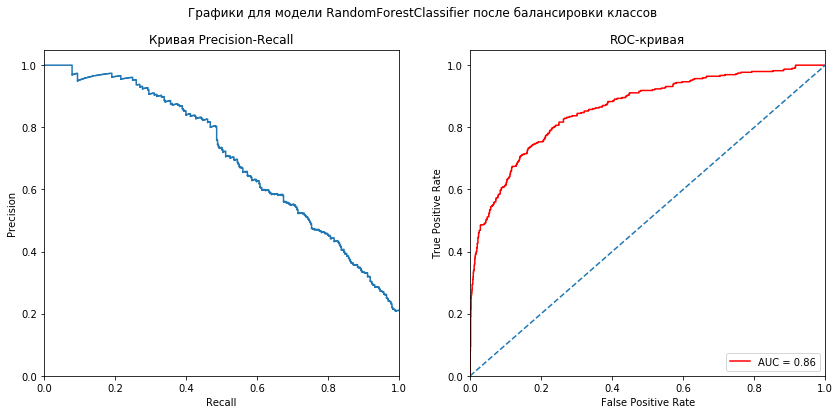

In [44]:
showplot(rfc_gs.best_estimator_, 'Графики для модели RandomForestClassifier после балансировки классов')

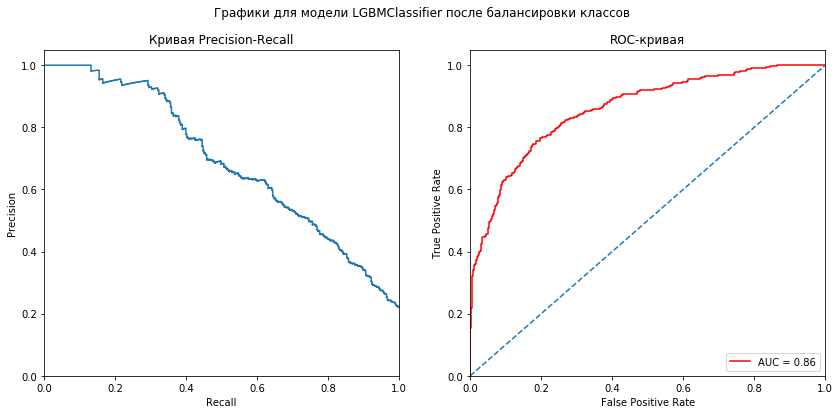

In [45]:
showplot(lgbm_gs.best_estimator_, 'Графики для модели LGBMClassifier после балансировки классов')

In [46]:
for i in range(len(models_balanced)):
    results_table(models_balanced[i], piplines_balanced[i], 'Гиперпараметр class_weight = balanced')

In [47]:
results.style.background_gradient(axis=0, cmap='YlOrRd')

,Метод борьбы с дисбалансом,Learning model,F1-score,AUC-ROC
0,Без учета дисбаланса,"DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best')",0.488,0.73
1,Без учета дисбаланса,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)",0.275,0.76
2,Без учета дисбаланса,"RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False)",0.604,0.86
3,Без учета дисбаланса,"LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, importance_type='split', learning_rate=0.1, max_depth=-1, min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31, objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0, subsample_for_bin=200000, subsample_freq=0)",0.58,0.86
4,Гиперпараметр class_weight = balanced,"DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best')",0.538,0.81
5,Гиперпараметр class_weight = balanced,"LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)",0.476,0.77
6,Гиперпараметр class_weight = balanced,"RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False)",0.595,0.86
7,Гиперпараметр class_weight = balanced,"LGBMClassifier(boosting_type='gbdt', class_weight='balanced', colsample_bytree=1.0, importance_type='split', learning_rate=0.1, max_depth=-1, min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31, objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0, subsample_for_bin=200000, subsample_freq=0)",0.593,0.86


Модель `LogisticRegression` оказалась очень чувствительна к балансировке классов: метрика F1 выросла с 0.275 до 0.476.  

Для остальных моделей метрика F1 после балансировки также изменилась, но в гораздо меньшей степени:

   - `DecisionTreeClassifier`: с 0.488 до 0.538;
   - `LGBMClassifier` - с 0.580 до 0.593;
   - `RandomForestClassifier`: F1-мера уменьшилась  с 0.604 до 0.593.

Продолжим подбор оптимальных параметров.  

#### 3. Увеличение выборки

Проверим, как на качество предсказания исследуемых моделей повлияет увеличение объема обучающей выборки.

Увеличим выборку, применив технику Upsampling. 
Upsampling выполняется в несколько этапов: 
1. Разделить обучающую выборку на отрицательные и положительные объекты;
2. Скопировать несколько раз положительные объекты;
3. С учётом полученных данных создать новую обучающую выборку;
4. Перемешать данные: идущие друг за другом одинаковые вопросы не помогут обучению.

In [48]:
# Напишем цикл для выполнения 4-х этапов Upsampling:

def upsample(X, y, repeat):
    X_zeros = X_train[y_train == 0]
    X_ones = X_train[y_train == 1]
    y_zeros = y_train[y_train == 0]
    y_ones = y_train[y_train == 1]
    X = pd.concat([X_zeros] + [X_ones] * repeat)
    y = pd.concat([y_zeros] + [y_ones] * repeat)
    X_upsampled, y_upsampled = shuffle(X, y, random_state=12345)
    return X_upsampled, y_upsampled

In [49]:
X_upsampled, y_upsampled = upsample(X_train, y_train, 4)
print(X_upsampled.shape)
print(y_upsampled.shape)

(9711, 10)
(9711,)


Обучим наши модели на получившейся выборке, и сравним значения F1 и AUC-ROC с предыдущими моделями.

In [50]:
%%time

# GridSearch DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
pipline_up_dtc = make_pipeline(col_transformer, model)
dtc_up_gs = GridSearchCV(pipline_up_dtc, param_grid=dtc_grid_params, cv=3, n_jobs=-1, scoring='f1')
dtc_up_gs.fit(X_upsampled, y_upsampled)                                                                                           

Wall time: 2.04 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categorical_features=None,
                                                                                       categories=None,
                                                                                       drop='first',
                                                                                       dtype=<class 'numpy.float64'

In [51]:
%%time

# GridSearch LogisticRegression
model = LogisticRegression(random_state=RANDOM_STATE)
pipline_up_lr = make_pipeline(col_transformer, model)
lr_up_gs = GridSearchCV(pipline_up_lr, param_grid=lr_grid_params, cv=3, n_jobs=-1, scoring='f1')
lr_up_gs.fit(X_upsampled, y_upsampled)

Wall time: 1.74 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categorical_features=None,
                                                                                       categories=None,
                                                                                       drop='first',
                                                                                       dtype=<class 'numpy.float64'

In [52]:
%%time

# GridSearch RandomForestClassifier
model = RandomForestClassifier(random_state=RANDOM_STATE)
pipline_up_rfc = make_pipeline(col_transformer, model)
rfc_up_gs = GridSearchCV(pipline_up_rfc, param_grid=rfc_grid_params, cv=3, n_jobs=-1, scoring='f1')
rfc_up_gs.fit(X_upsampled, y_upsampled)

Wall time: 4min 38s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categorical_features=None,
                                                                                       categories=None,
                                                                                       drop='first',
                                                                                       dtype=<class 'numpy.float64'

In [53]:
%%time

# GridSearch LGBMClassifier
model = LGBMClassifier(random_state=RANDOM_STATE)
pipline_up_lgbm = make_pipeline(col_transformer, model)
lgbm_up_gs = GridSearchCV(pipline_up_lgbm, param_grid=lgbm_grid_params, cv=3, n_jobs=-1, scoring='f1')
lgbm_up_gs.fit(X_upsampled, y_upsampled)

Wall time: 3.82 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categorical_features=None,
                                                                                       categories=None,
                                                                                       drop='first',
                                                                                       dtype=<class 'numpy.float64'

In [54]:
# Список моделей после Upsampling для расчета метрик и результирующей таблицы:

models_up = [
    dtc_up_gs.best_estimator_,
    lr_up_gs.best_estimator_,
    rfc_up_gs.best_estimator_,
    lgbm_up_gs.best_estimator_
]
piplines_up = [
    pipline_up_dtc, 
    pipline_up_lr, 
    pipline_up_rfc, 
    pipline_up_lgbm
]

In [55]:
for i in range(len(models_up)):
    metrics_calc(models_up[i], piplines_up[i])

Метрики для модели: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

Accuracy модели на валидационной выборке: 0.78
Полнота модели на валидационной выборке: 0.66
Точность модели на валидационной выборке: 0.46
Площадь под ROC-кривой - AUC-ROC: 0.81
Значение F1-меры модели на валидационной выборке: 0.538

###########################################################

Метрики для модели: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='war

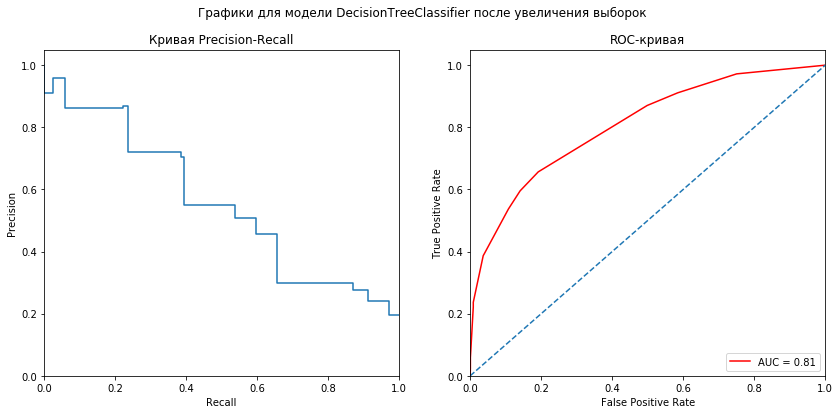

In [56]:
showplot(dtc_up_gs.best_estimator_, 'Графики для модели DecisionTreeClassifier после увеличения выборок')

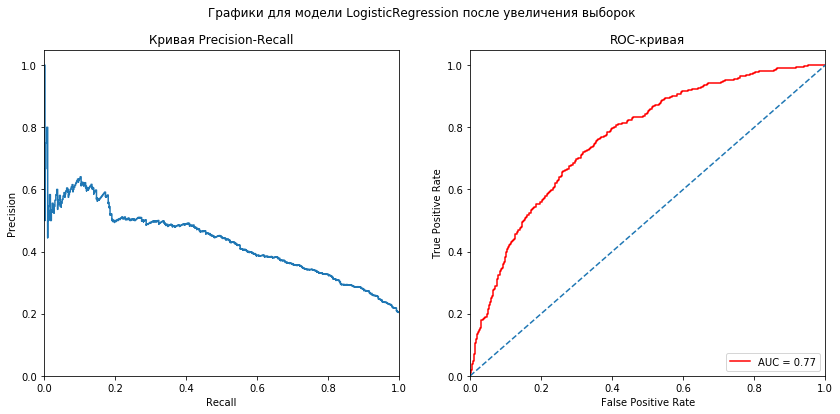

In [57]:
showplot(lr_up_gs.best_estimator_, 'Графики для модели LogisticRegression после увеличения выборок')

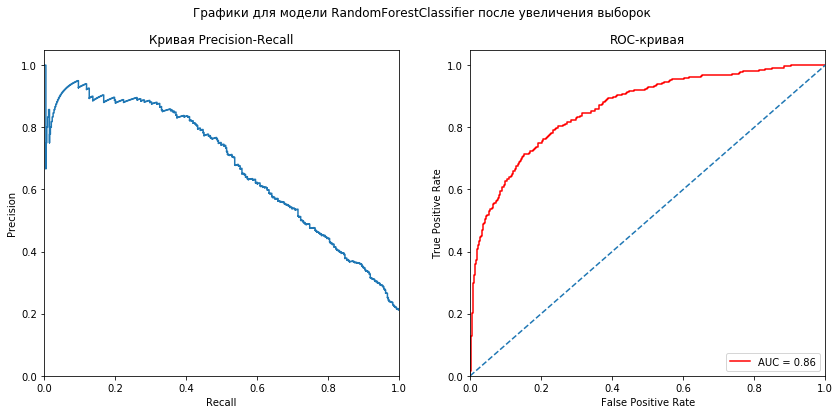

In [58]:
showplot(rfc_up_gs.best_estimator_, 'Графики для модели RandomForestClassifier после увеличения выборок')

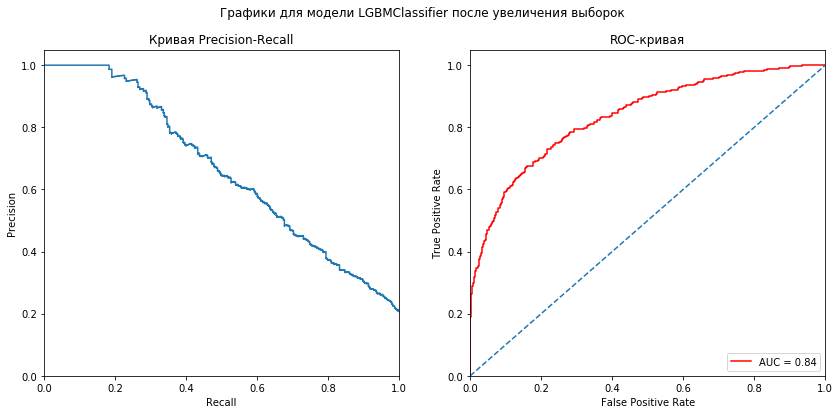

In [59]:
showplot(lgbm_up_gs.best_estimator_, 'Графики для модели LGBMClassifier после увеличения выборок')

In [60]:
for i in range(len(models_up)):
    results_table(models_up[i], piplines_up[i], 'Upsampling')

In [61]:
results.style.background_gradient(axis=0, cmap='YlOrRd')

,Метод борьбы с дисбалансом,Learning model,F1-score,AUC-ROC
0,Без учета дисбаланса,"DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best')",0.488,0.73
1,Без учета дисбаланса,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)",0.275,0.76
2,Без учета дисбаланса,"RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False)",0.604,0.86
3,Без учета дисбаланса,"LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, importance_type='split', learning_rate=0.1, max_depth=-1, min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31, objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0, subsample_for_bin=200000, subsample_freq=0)",0.58,0.86
4,Гиперпараметр class_weight = balanced,"DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best')",0.538,0.81
5,Гиперпараметр class_weight = balanced,"LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)",0.476,0.77
6,Гиперпараметр class_weight = balanced,"RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False)",0.595,0.86
7,Гиперпараметр class_weight = balanced,"LGBMClassifier(boosting_type='gbdt', class_weight='balanced', colsample_bytree=1.0, importance_type='split', learning_rate=0.1, max_depth=-1, min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31, objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0, subsample_for_bin=200000, subsample_freq=0)",0.593,0.86
8,Upsampling,"DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best')",0.538,0.81
9,Upsampling,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)",0.476,0.77


По сравнению с балансировкой классов, значение метрики F1 после апсемплинга увеличилось у одной модели:

   - `RandomForestClassifier`: с 0.593 до 0.611.
   
В случае с остальными моделями использование апсемплинга не изменило либо уменьшило значение F1-меры:   
   
   - `DecisionTreeClassifier`: F1-мера не изменилась;
   - `LogisticRegression`: F1-мера не изменилась;
   - `LGBMClassifier`: значение F1-меры уменьшилось с 0.593 до 0.577.

### Изменение порога классификации

Проверим, как на качество предсказания исследуемых моделей повлияет изменение порога классификации. Для проверки возьмем модели без учета дисбаланса классов, подобранные с перебором гиперпараметров.

In [62]:
# Список моделей без учета дисбаланса классов:

models = [
    dtc_gs.best_estimator_,
    lr_gs.best_estimator_,
    rfc_gs.best_estimator_,
    lgbm_gs.best_estimator_
]

In [63]:
# 1 модель - DecisionTreeClassifier()

model = dtc_gs.best_estimator_
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_threshold_dtc_model = None
best_f1_dtc_thr = 0
best_auc_roc_dtc_thr = 0
best_threshold_dtc = 0

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1_valid = f1_score(y_valid, predicted_valid)
    auc_roc_valid = roc_auc_score(y_valid, probabilities_one_valid)
    
    if f1_valid > best_f1_dtc_thr:
        best_threshold_dtc_model = model
        best_f1_dtc_thr = f1_valid
        best_auc_roc_dtc_thr = auc_roc_valid
        best_threshold_dtc = threshold

print('Модель:', best_threshold_dtc_model)
print('Порог классификации = ', best_threshold_dtc)
print('F1 на валидационной выборке после изменения порога классификации: F1 = {:.3f}'.format(best_f1_dtc_thr))
print('AUC-ROC на валидационной выборке после изменения порога классификации: AUC-ROC = {:.3f}'.format(best_auc_roc_dtc_thr))

Модель: Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['geography', 'gender']...
       

In [64]:
# 2 модель - LogisticRegression()

model = lr_gs.best_estimator_
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_threshold_lr_model = None
best_f1_lr_thr = 0
best_auc_roc_lr_thr = 0
best_threshold_lr = 0

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1_valid = f1_score(y_valid, predicted_valid)
    auc_roc_valid = roc_auc_score(y_valid, probabilities_one_valid)
    
    if f1_valid > best_f1_lr_thr:
        best_threshold_lr_model = model
        best_f1_lr_thr = f1_valid
        best_auc_roc_lr_thr = auc_roc_valid
        best_threshold_lr = threshold

print('Модель:', best_threshold_lr_model)
print('Порог классификации = ', best_threshold_lr)
print('F1 на валидационной выборке после изменения порога классификации: F1 = {:.3f}'.format(best_f1_lr_thr))
print('AUC-ROC на валидационной выборке после изменения порога классификации: AUC-ROC = {:.3f}'.format(best_auc_roc_lr_thr))

Модель: Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['geography', 'gender']...
       

In [65]:
# 3 модель - RandomForestClassifier()

model = rfc_gs.best_estimator_
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_threshold_rfc_model = None
best_f1_rf_thr = 0
best_auc_roc_rf_thr = 0
best_threshold_rf = 0

for threshold in np.arange(0, 0.52, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1_valid = f1_score(y_valid, predicted_valid)
    auc_roc_valid = roc_auc_score(y_valid, probabilities_one_valid)

    if f1_valid > best_f1_rf_thr:
        best_threshold_rfc_model = model
        best_f1_rf_thr = f1_valid
        best_auc_roc_rf_thr = auc_roc_valid
        best_threshold_rf = threshold

print('Модель:', best_threshold_rfc_model)
print('Порог классификации = ', best_threshold_rf)
print('F1 на валидационной выборке после изменения порога классификации: F1 = {:.3f}'.format(best_f1_rf_thr))
print('AUC-ROC на валидационной выборке после изменения порога классификации: AUC-ROC = {:.3f}'.format(best_auc_roc_rf_thr))

Модель: Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['geography', 'gender']...
       

In [66]:
# 4 модель - LGBMClassifier()

model = lgbm_gs.best_estimator_
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_threshold_lgbm_model = None
best_f1_lgbm_thr = 0
best_auc_roc_lgbm_thr = 0
best_threshold_lgbm = 0

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1_valid = f1_score(y_valid, predicted_valid)
    auc_roc_valid = roc_auc_score(y_valid, probabilities_one_valid)
    
    if f1_valid > best_f1_lgbm_thr:
        best_threshold_lgbm_model = model
        best_f1_lgbm_thr = f1_valid
        best_auc_roc_lgbm_thr = auc_roc_valid
        best_threshold_lgbm = threshold

print('Модель:', best_threshold_lgbm_model)
print('Порог классификации = ', best_threshold_lgbm)
print('F1 на валидационной выборке после изменения порога классификации: F1 = {:.3f}'.format(best_f1_lgbm_thr))
print('AUC-ROC на валидационной выборке после изменения порога классификации: AUC-ROC = {:.3f}'.format(best_auc_roc_lgbm_thr))

Модель: Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['geography', 'gender']...
       

In [67]:
# Создадим список новых моделей для расчета метрик:

models_threshold = [
    best_threshold_dtc_model,
    best_threshold_lr_model,
    best_threshold_rfc_model,
    best_threshold_lgbm_model
]
piplines = [
    pipline_dtc, 
    pipline_lr, 
    pipline_rfc, 
    pipline_lgbm
]

In [68]:
for i in range(len(models_threshold)):
    metrics_calc(models_threshold[i], piplines[i])

Метрики для модели: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

Accuracy модели на валидационной выборке: 0.83
Полнота модели на валидационной выборке: 0.42
Точность модели на валидационной выборке: 0.58
Площадь под ROC-кривой - AUC-ROC: 0.73
Значение F1-меры модели на валидационной выборке: 0.488

###########################################################

Метрики для модели: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='war

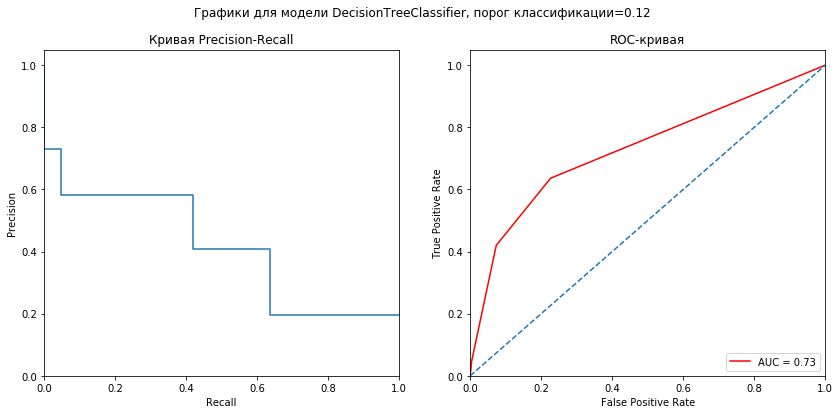

In [69]:
showplot(best_threshold_dtc_model, 'Графики для модели DecisionTreeClassifier, порог классификации=0.12')

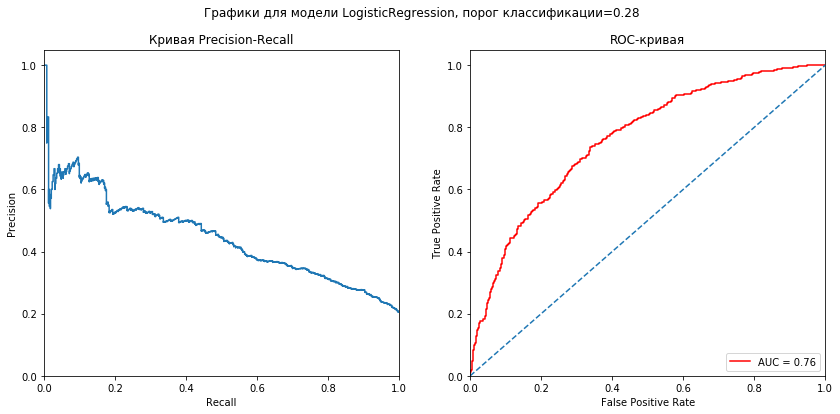

In [70]:
showplot(best_threshold_lr_model, 'Графики для модели LogisticRegression, порог классификации=0.28')

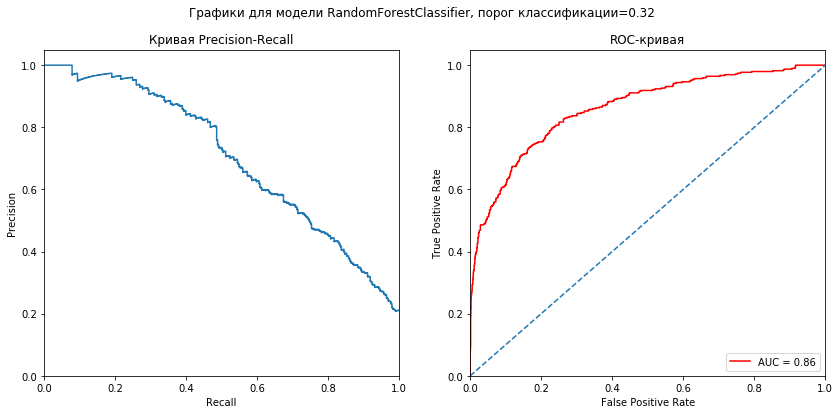

In [71]:
showplot(best_threshold_rfc_model, 'Графики для модели RandomForestClassifier, порог классификации=0.32')

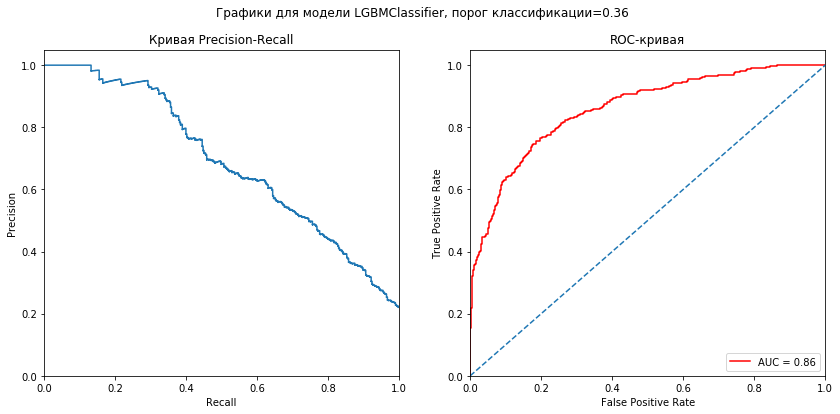

In [72]:
showplot(best_threshold_lgbm_model, 'Графики для модели LGBMClassifier, порог классификации=0.36')

In [73]:
# Функция для вывода результирующей таблицы(вносим изменения для добавления моделей с порогом)

def results_table(model, threshold, f1, pipline, contre_disbalance_way:str):
    globals()['results'] = globals()['results'].append(
      {'Метод борьбы с дисбалансом' : contre_disbalance_way, 
       'Learning model': [pipline.steps[1][1], 'порог=',threshold],
       'F1-score': f1.round(3),
       'AUC-ROC': auc_calc(model).round(2)
      }, 
          ignore_index=True)
    
    return

In [74]:
# Создаем списки переменных для передачи в функцию

models_threshold = [
    best_threshold_dtc_model,
    best_threshold_lr_model,
    best_threshold_rfc_model,
    best_threshold_lgbm_model
]
thresholds = [
    best_threshold_dtc,
    best_threshold_lr, 
    best_threshold_rf, 
    best_threshold_lgbm
]
best_f1 = [
    best_f1_dtc_thr, 
    best_f1_lr_thr, 
    best_f1_rf_thr, 
    best_f1_lgbm_thr
]
piplines = [
    pipline_dtc, 
    pipline_lr, 
    pipline_rfc, 
    pipline_lgbm
]

In [75]:
# Запускаем цикл для добавления новых результатов в таблицу:

for i in range(len(models_threshold)):
    results_table(models_threshold[i], thresholds[i], best_f1[i], piplines[i], 'Изменение порога классификации')

Мы исследовали 16 моделей. Сведем все полученные метрики в одну таблицу и выберем лучшую модель:

In [76]:
# Выводим полную результирующую таблицу

results.style.background_gradient(axis=0, cmap='YlOrRd')

,Метод борьбы с дисбалансом,Learning model,F1-score,AUC-ROC
0,Без учета дисбаланса,"DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best')",0.488,0.73
1,Без учета дисбаланса,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)",0.275,0.76
2,Без учета дисбаланса,"RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False)",0.604,0.86
3,Без учета дисбаланса,"LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, importance_type='split', learning_rate=0.1, max_depth=-1, min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31, objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0, subsample_for_bin=200000, subsample_freq=0)",0.58,0.86
4,Гиперпараметр class_weight = balanced,"DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best')",0.538,0.81
5,Гиперпараметр class_weight = balanced,"LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)",0.476,0.77
6,Гиперпараметр class_weight = balanced,"RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False)",0.595,0.86
7,Гиперпараметр class_weight = balanced,"LGBMClassifier(boosting_type='gbdt', class_weight='balanced', colsample_bytree=1.0, importance_type='split', learning_rate=0.1, max_depth=-1, min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31, objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0, subsample_for_bin=200000, subsample_freq=0)",0.593,0.86
8,Upsampling,"DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best')",0.538,0.81
9,Upsampling,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)",0.476,0.77


Изменение порога классификации улучшило качество моделей:
   
   - Качество `DecisionTreeClassifier` с подобранный новым порогом классификации = 0.12 увеличилось с 0.488 до 0.497, значение AUC-ROC не изменилось. Значение F1-меря не дотягивает до требуемого, при этом, порог классификации = 0.12 кажется экстремально низким.
   
   - Качество `LogisticRegression` заметно выросло: с подобранный новым порогом классификации = 0.28 F1-мера увеличилась с 0.275 до 0.473, значение AUC-ROC не изменилось. 
   
   - Качество `RandomForestClassifier` выросло: с подобранный новым порогом классификации = 0.32 F1-мера увеличилась с 0.604 до 0.618, значение AUC-ROC не изменилось. 
   
   - Качество `LGBMClassifier` также выросло: с подобранный новым порогом классификации = 0.36 F1-мера увеличилась с 0.580 до 0.625, значение AUC-ROC не изменилось.

Как видно из таблицы, самые высокие метрики показывают модели после изменения порога классификации:
   - `RandomForestClassifier` с порогом 0.32: F1 = 0.618, AUC-ROC = 0.86;
   - `LGBMClassifier` с порогом 0.36: F1 = 0.625, AUC-ROC = 0.860
   
Итоговой выбираем модель с самым высоким значением F1-меры - `LGBMClassifier` с порогом классификации 0.36.

### Финальное тестирование модели

Протестируем итоговую модель.

In [108]:
model = best_threshold_lgbm_model
predicted_test = model.predict(X_test)
f1_test = f1_score(y_test, predicted_test)
        
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)

print('Модель: LGBMClassifier, ')
print()
print('F1 на тесте: F1 = {:.2f}'.format(f1_test))
print()
print('AUC-ROC на тесте: AUC-ROC = {:.2f}'.format(auc_roc))

Модель: LGBMClassifier, 

F1 на тесте: F1 = 0.59

AUC-ROC на тесте: AUC-ROC = 0.85


### ВЫВОД

Перед нами стояла задача классификации - спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

В ходе работы над проектом были проведены следующие исследования и получены соотвествующие результаты:

   1. Подготовка и обзор данных:
       - заполнение пропусков,
       - удаление строк и столбцов, не нужных при исследовании.
     
     
   2. За основу исследования взяты четыре базовые модели, которые показали следующее качество:
       - `DecisionTreeClassifier`: F1=0.49, AUC-ROC=0.73;
       - `LogisticRegression`: F1=0.28, AUC-ROC=0.76; 
       - `RandomForestClassifier`: F1=0.60, AUC-ROC=0.86;  
       - `LGBMClassifier`: F1=0.54, AUC-ROC=0.81


   3. Отличительной особенностью предоставленных данных был сильный дисбаланс классов в целевом признаке, соотношение классов составило 0.8 / 0.2. 
В ходе работы над проектом были исследованы разные методы борьбы с дисбалансом классов и их влияние на качество прогноза 4-х выбранных моделей: 

   3.1 **Балансировка классов с  помощью гиперпараметра class_weight = balanced** дала следующие результаты:  
        
       - Модель `LogisticRegression` оказалась очень чувствительна к балансировке классов: метрика F1 выросла с 0.275 до 0.476.
       - Для остальных моделей метрика F1 после балансировки также изменилась, но в гораздо меньшей степени.

   3.2. **Увеличение выборки** дало повышение качества только у одной модели - `RandomForestClassifier`, F1 выросла с 0.593 до 0.611. В случае с остальными моделями использование апсемплинга не изменило либо уменьшило значение F1-меры.

   3.3. **Изменение порога классификации** улучшило качество всех моделей, причем для моделей `RandomForestClassifier` и `LGBMClassifier` удалось довести показатель F1 до значений выше 0.60.
   
   
   4. В результате исследования из 16 вариантов была выбрана наилучшая модель `LGBMClassifier` с порогом классификации 0.36.
   
   
   5. Тестирование итоговой модели дало следующие результаты: F1 = 0.59, AUC-ROC = 0.85.

Таким образом, задача, поставленная изначально, выполнена.